# [실습] 소재물성 예측을 위한 그래프 신경망 (GNN)


## 실습 목표
---
- 토이데이터를 읽어와 GNN을 학습시켜 baseline 성능과 비교한다.
- 소재물성 데이터를 가져와 GNN 모델을 학습시킨다.


## 실습 목차
---

1. **토이데이터 전처리:** Cora 데이터 전처리 및 인공지능 모델 입력 형태로 변형

2. **베이스라인 모델 훈련:** 단순한 인공신경망을 이용해 토이데이터 훈련

3. **GNN 모델 훈련 (Cora 데이터):** GNN 모델을 토이데이터셋에 대해 훈련

4. **GNN 모델 훈련 (소재물성 데이터):** 데이터 전처리 및 GNN 모델을 이용해 소재물성 데이터 예측

5. **연습문제 :** Cora데이터 전처리 및 GNN모델링 훈련 전과정 수행

## 실습 개요
---

소재물성 예측을 위해 GNN 모델을 이해합니다.


## 1. 토이데이터 전처리

### 1.1 라이브러리 불러오기

---

필요한 라이브러리를 호출합니다.
 - **numpy**: 수치형 데이터를 배열 구조로 처리하기 위한 라이브러리
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **matplotlib.pyplot**: 데이터시각화를 위한 라이브러리
 - **tensorflow** : 대표적인 딥러닝 프레임워크
 - **networkx** : 그래프와 네트워크를 연구하기위한 Python 라이브러리

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 1.2 Cora데이터셋 불러오기
---
문서와, 각 문서의 카테고리 분류로 이루어진 데이터\
citation : 문서의 인용/피인용 지칭 데이터\
paper: 어느 주제인지 (subject), 어느 단어가 있는지 (term) 으로 이루어져 있는 데이터

Cora 데이터세트는 노드가 머신러닝 논문을 나타내고 간선이 논문 쌍 간의 인용을 나타내는 인용 그래프입니다. 관련된 작업은 각 논문을 7가지 범주 중 하나로 분류하는 것을 목표로 하는 문서 분류입니다. 즉, 7개의 클래스가 있는 다중 클래스 분류 문제입니다.

먼저 데이터를 다운로드하고 citations 데이터를 데이터프레임화 시켜 불러오겠습니다.

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations['source']

0          1033
1        103482
2        103515
3       1050679
4       1103960
         ...   
5424      19621
5425     853155
5426    1140289
5427     853118
5428    1155073
Name: source, Length: 5429, dtype: int64

In [5]:
citations.sample(frac=1).head()

,target,source
1977,14428,1103031
165,35,98698
725,3101,70441
1829,12238,1112099
1187,6169,1106406


다음으로 papers 데이터를 판다스 데이터프레임 형태로 불러오겠습니다.

In [6]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [7]:
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [8]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


papers 데이터 안의 각각의 subject들의 카운트를 확인해봅시다.

In [9]:
print(papers.subject.value_counts()) # 각 주제별 데이터 (paper) 수

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


### 1.3 데이터 전처리
---
인덱스가 뒤죽박죽이므로 이를 정렬\
subject가 카테고리 인덱스로 변경합니다. (0~7 사이의 값으로 변환)

In [10]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [11]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [12]:
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [13]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [14]:
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [15]:
citations

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940
...,...,...
5424,1873,328
5425,1873,1876
5426,1874,2586
5427,1876,1874


### 1.4. 데이터 시각화
---
paper의 인용/피인용 데이터를 시각화합니다. (그래프화, 특정 paper가 어떤 paper들과 연결되어있는지를 표시)\
각 노드는 논문을 나타내고 노드의 색은 subject에 해당합니다. \
이를 이후 GNN학습에 이용할 예정입니다.

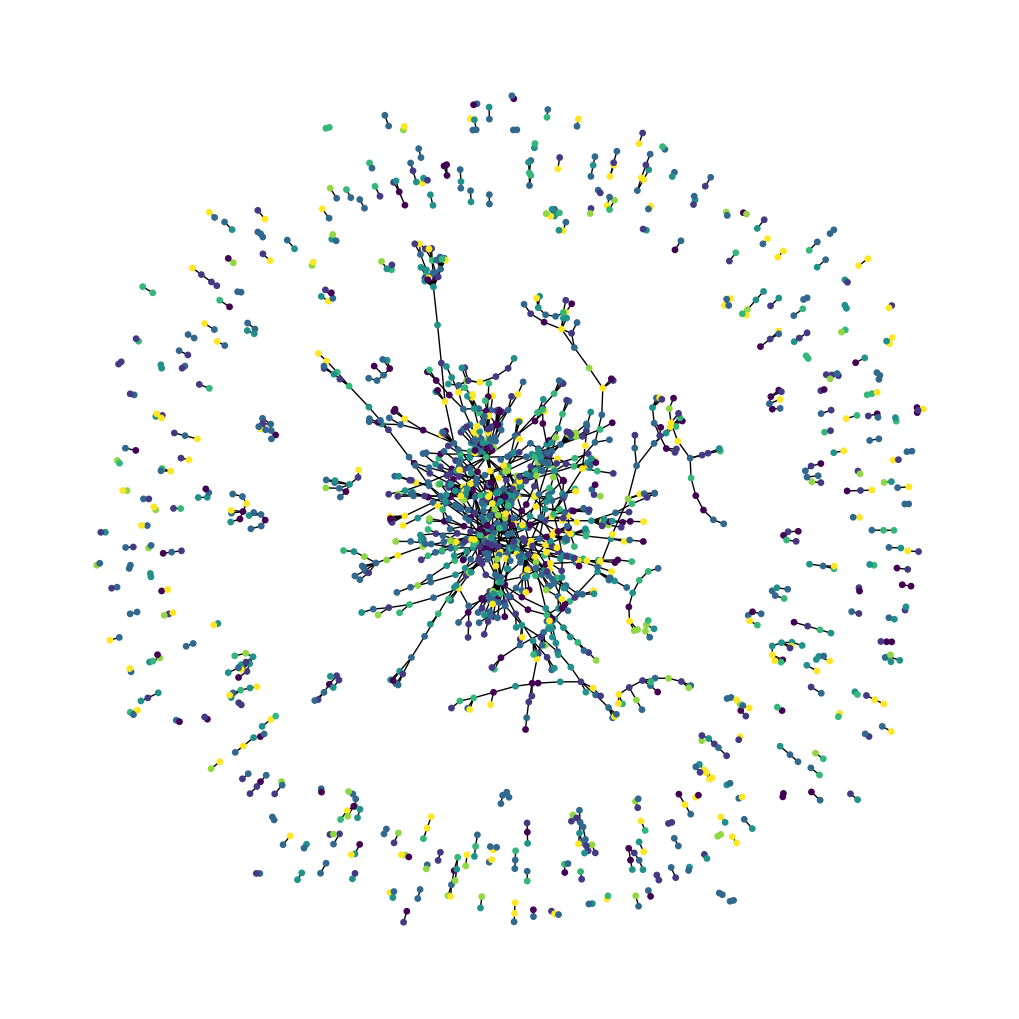

In [16]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

## 2. 베이스라인 모델 훈련

### 2.1. 인공신경망 인풋 준비
---
전체 데이터를 학습/시험 데이터로 분리합니다. \
그리고 훈련에 사용할 하이퍼파라미터를 선언합니다.

In [17]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # 학습 / 시험 데이터를 1:1로 분리
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1374, 1435)
Test data shape: (1334, 1435)


In [18]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

### 2.2. 인공신경망 모델 준비
---
훈련할 모델과 훈련한 결과를 시각화할 함수를 정의합니다. 앞서 선언한 하이퍼파라미터를 이용해 훈련을 진행하도록 하겠습니다. \
아래의 순서대로 코드가 진행됩니다.
- 모델 훈련을 진행해주는 함수를 정의합니다.
- 훈련결과를 확인할 수 있는 시각화 함수를 정의합니다.
- 모델을 선언하는 함수를 정의합니다.
- Baseline 모델을 훈련할 데이터를 준비합니다.
- skip connection을 가지는 5개의 FFN block이 추가된 모델을 생성합니다.

In [19]:
# 모델 훈련 함수
def run_experiment(model, x_train, y_train):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [20]:
# 훈련결과 시각화 함수
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [21]:
# 모델 선언 함수
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    # 모델 구조 확인
    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [22]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# 인풋 데이터를 넘파이 데이터로 변환
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# 정답 데이터를 넘파이 데이터로 변환
y_train = train_data["subject"]
y_test = test_data["subject"]

In [23]:
# 모델 생성 함수
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # FFN 블락 생성
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Skip 연결 (ResNet 참조)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # logit 계산
    logits = layers.Dense(num_classes, name="logits")(x)
    # 모델 생성
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary() # 모델 구조 확인

2025-05-22 10:23:04.969471: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-22 10:23:04.969510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-22 10:23:04.969526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-22 10:23:04.969582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-22 10:23:04.969602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

### 2.3. 인공신경망 모델 훈련
---

준비해놓은 데이터를 토대로 Baseline_model의 훈련을 진행하겠습니다.

In [24]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300


2025-05-22 10:23:08.160805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 3.3453 - acc: 0.1825

2025-05-22 10:23:10.988763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 337ms/step - loss: 3.3453 - acc: 0.1825 - val_loss: 1.9422 - val_acc: 0.2560
Epoch 2/300
5/5 [==============================] - 0s 28ms/step - loss: 2.5823 - acc: 0.2117 - val_loss: 1.9152 - val_acc: 0.3140
Epoch 3/300
5/5 [==============================] - 0s 28ms/step - loss: 2.4419 - acc: 0.2408 - val_loss: 1.9153 - val_acc: 0.3382
Epoch 4/300
5/5 [==============================] - 0s 27ms/step - loss: 2.1864 - acc: 0.2442 - val_loss: 1.9056 - val_acc: 0.3816
Epoch 5/300
5/5 [==============================] - 0s 23ms/step - loss: 2.0821 - acc: 0.2468 - val_loss: 1.8795 - val_acc: 0.3285
Epoch 6/300
5/5 [==============================] - 0s 23ms/step - loss: 1.9234 - acc: 0.2793 - val_loss: 1.8443 - val_acc: 0.3140
Epoch 7/300
5/5 [==============================] - 0s 23ms/step - loss: 1.8879 - acc: 0.3128 - val_loss: 1.8217 - val_acc: 0.3140
Epoch 8/300
5/5 [==============================] - 0s 23ms/step - loss: 1.8264 - acc: 0.3265 - val_lo

조기 종료의 영향으로 119 epoch에서 훈련이 종료되었습니다. 그래프로 시각화해서 살펴보겠습니다.

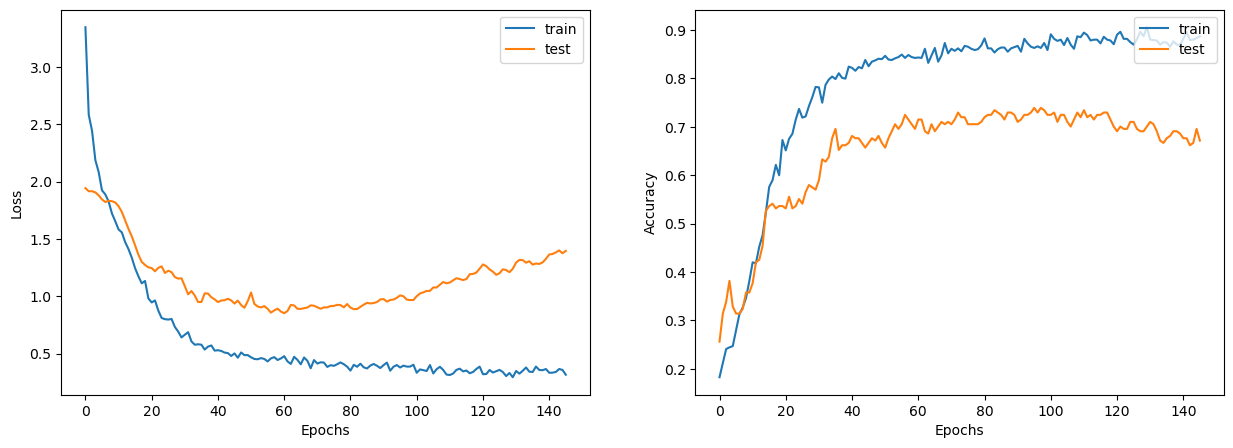

In [25]:
display_learning_curves(history)

### 2.4. 인공신경망 모델 평가
---

모델의 검증데이터를 통한 훈련 정확도를 살펴보겠습니다. \
약 73%의 결과를 보이고 있습니다.

In [26]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.39%


## 3. GNN 훈련

### 3.1.  GNN 인풋 준비
---
데이터의 그래프화를 진행합니다. \
citation 정보를 이용해 그래프를 생성합니다.

그래프 데이터는 아래 3가지 요소로 구성되어있습니다.
- node_feature : 노드의 특성을 포함하는 넘파이 배열입니다.
- edges : 노드들 간의 희소인접행렬을 나타내는 넘파이 배열입니다.
- edge_weights : 그래프의 노드 간의 관계를 정량화하는 edge 가중치를 포함하는 넘파이 배열입니다. \
각각의 정의해 graph_info에 담아줍니다.

In [27]:
# edge arry 생성 [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# edge의 weight를 1로 초기화 [len(edges),]
edge_weights = tf.ones(shape=edges.shape[1])
# node의 feature array 생성 [num_nodes, num_features]
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# 위 정보들을 모두 담은 graph_info 튜플 변수 선언
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### 3.2.  GNN 모델 준비
---

GNN 모델을 수행하기 위한 준비를 하겠습니다. 먼저 GraphConvLayer를 활용하기 위해 함수로 정의합니다. \
GraphConvLayer를 정의하기위해서는 prepare , Aggregate, Update 3단계를 정의합니다.

In [28]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

분류 문제를 해결하기 위한 GNN 분류기를 구현합니다. \
- 아래 과정을 따릅니다.
1. 초기 노드 표현을 생성하기 위해 FFN을 사용한 전처리를 적용합니다.
2. skip연결이 있는 GraphConvLayer를 노드 표현에 적용해 노드 임베딩을 생성합니다.
3. FFN을 사용한 후 노드 임베딩을 적용해 최종 노드 임베딩을 생성합니다.
4. softmax 계층을 통과시켜 노드 클래스를 예측합니다.


In [29]:
# GNN 모델 선언
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

모델을 생성하고 구조를 확인합니다.

In [30]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.04208838 -0.01320994  0.03845268 -0.06311873 -0.05007514 -0.03582076
  -0.02012489]
 [ 0.07307252  0.01294737 -0.04361938 -0.04792996 -0.14460129 -0.01028017
   0.03704375]
 [ 0.1465043  -0.10502449 -0.04318758 -0.0444331  -0.09216043  0.00305806
   0.02696961]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                            

### 3.3.  GNN 모델 훈련
---

이제 데이터와 모델 준비가 끝났습니다. 본격적으로 학습을 진행해보겠습니다.

In [31]:
# x_train.shape
y_train.shape # 인풋데이터 확인

(1374,)

In [32]:
# 인풋: 노드의 인덱스
# 아웃풋: 노드와 엣지 정보를 이용하여 나온 예측결과
x_train = train_data.paper_id.to_numpy() 
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300


2025-05-22 10:24:03.632661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 2.2549 - acc: 0.1645

2025-05-22 10:24:05.994278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 169ms/step - loss: 2.2549 - acc: 0.1645 - val_loss: 1.9252 - val_acc: 0.1594
Epoch 2/300
5/5 [==============================] - 0s 37ms/step - loss: 1.7189 - acc: 0.3539 - val_loss: 1.8990 - val_acc: 0.2754
Epoch 3/300
5/5 [==============================] - 0s 31ms/step - loss: 1.4615 - acc: 0.4516 - val_loss: 1.8907 - val_acc: 0.2657
Epoch 4/300
5/5 [==============================] - 0s 31ms/step - loss: 1.2293 - acc: 0.5621 - val_loss: 1.8878 - val_acc: 0.2367
Epoch 5/300
5/5 [==============================] - 0s 31ms/step - loss: 0.9625 - acc: 0.6915 - val_loss: 1.8874 - val_acc: 0.1884
Epoch 6/300
5/5 [==============================] - 0s 31ms/step - loss: 0.7056 - acc: 0.7901 - val_loss: 1.8762 - val_acc: 0.2174
Epoch 7/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4937 - acc: 0.8518 - val_loss: 1.8585 - val_acc: 0.2222
Epoch 8/300
5/5 [==============================] - 0s 33ms/step - loss: 0.3262 - acc: 0.9075 - val_lo

훈련 결과를 시각화를 통해 살펴보겠습니다. 조기 종료로 인해 156 epoch까지 훈련이 진행되었습니다.

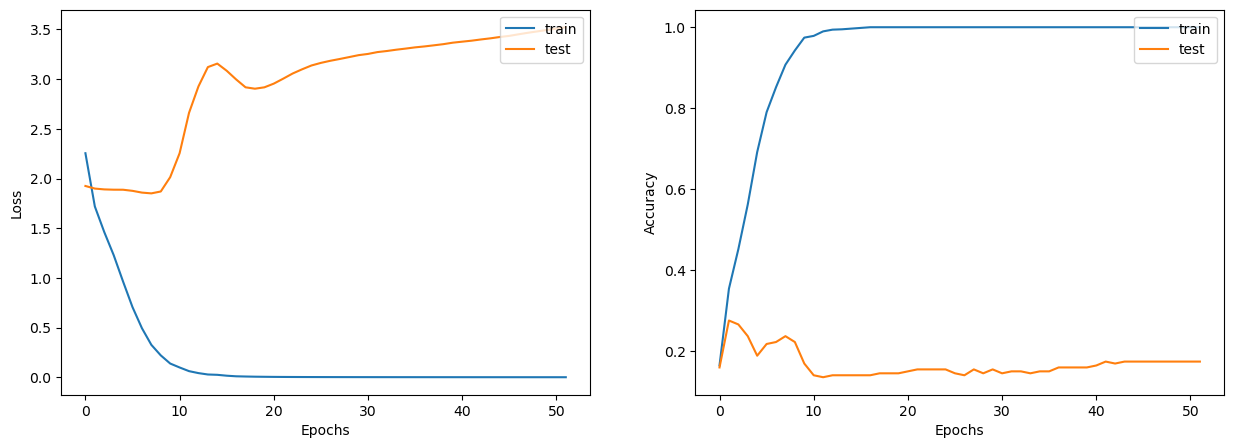

In [33]:
display_learning_curves(history)

### 3.4.  GNN 모델 평가
---

결과를 정확도를 통해 알아보겠습니다. 79%로 이전 Baseline 모델보다 좋은 성능을 보이고 있는것을 확인할 수 있습니다.

In [34]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 30.51%


## 4. GNN을 이용한 소재물성 예측

### 4.1.  라이브러리 임포트
---

필요한 라이브러리를 호출합니다.
 - **numpy**: 수치형 데이터를 배열 구조로 처리하기 위한 라이브러리
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **matplotlib.pyplot**: 데이터시각화를 위한 라이브러리
 - **seaborn**: 시각화 라이브러리
 - **sklearn**: 다양한 분류, 회귀, 그리고 서포트 벡터 머신, 랜덤 포레스트, 그라디언트 부스팅, k-평균, DBSCAN을 포함한 클러스터링 알고리즘을 사용가능한 기계학습 라이브러리

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,mean_squared_error
%matplotlib inline
seed=42

### 4.2. 데이터 로드
---

소재 물성 데이터를 로드합니다.

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [37]:
print('Number of rows and columns in train data set:',train.shape)
print('Number of rows and columns in test data  set:',test.shape)

Number of rows and columns in train data set: (2400, 14)
Number of rows and columns in test data  set: (600, 12)


In [38]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


Regression 모델 평가를 위한 RMSLE(Root Mean Squared Error)를 생성하는 함수를 정의합니다.

In [39]:
def rmsle(y_true,y_pred):
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

### 4.3.  데이터 전처리 및 컬럼 추가
--- 

소재물성 데이터의 전처리를 진행하겠습니다. \
먼저 데이터의 분포를 살펴보고, discribe()를 사용해 통께 지표와 corr()를 활용해 상관관계를 살펴보겠습니다. \
이후 데이터에 필요한 컬럼들을 추가해주도록 하겠습니다.

/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_34685/2831187267.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['formation_energy_ev_natom'],bins=50,ax=ax1,color='b')
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_34685/2831187267.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

<Axes: xlabel='bandgap_energy_ev', ylabel='Density'>

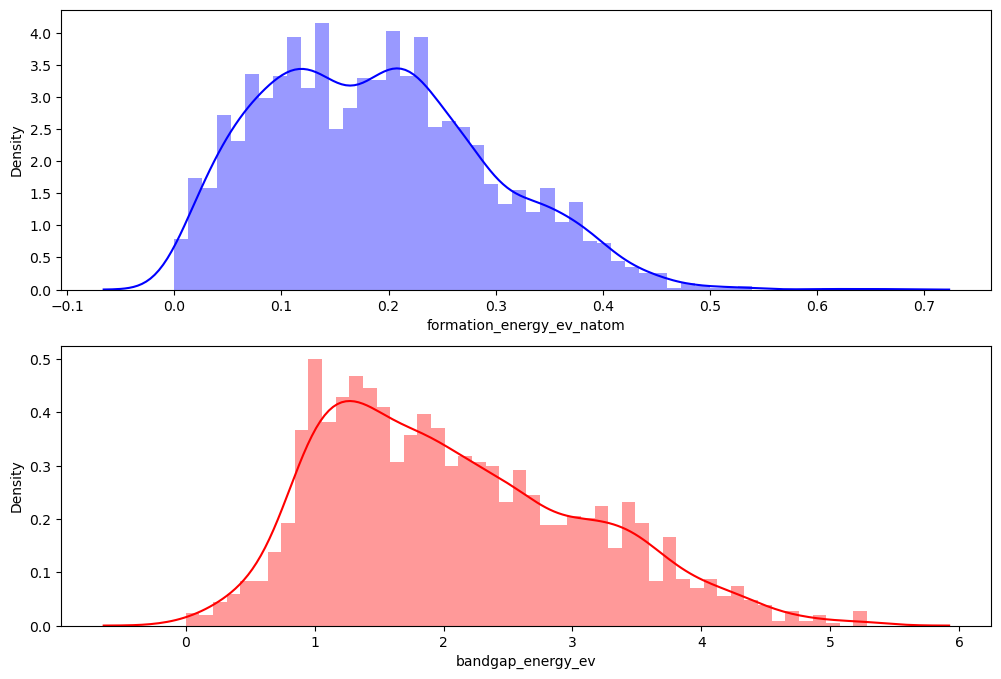

In [40]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax1,ax2 = ax.flatten()
sns.distplot(train['formation_energy_ev_natom'],bins=50,ax=ax1,color='b')
sns.distplot(train['bandgap_energy_ev'],bins=50,ax=ax2,color='r')

In [41]:
train.describe()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1200.500000,141.517917,61.679167,0.385439,0.308601,0.305958,10.030005,7.086977,12.593288,90.243666,92.398971,94.787600,0.187614,2.077205
std,692.964646,84.715548,22.598337,0.265566,0.233717,0.263198,5.645457,1.890330,5.450746,1.333655,5.299734,25.868516,0.104100,1.006845
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,600.750000,33.000000,40.000000,0.166700,0.093800,0.062500,6.141100,5.833625,9.298000,89.999700,90.000900,89.998700,0.105600,1.278500
50%,1200.500000,194.000000,80.000000,0.375000,0.281200,0.250000,9.537450,6.382950,10.125000,90.001700,90.003550,90.000400,0.181800,1.907850
75%,1800.250000,206.000000,80.000000,0.583300,0.468800,0.468800,10.292100,9.093450,14.372050,90.006200,90.014400,119.998325,0.256275,2.761950
max,2400.000000,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


<Axes: >

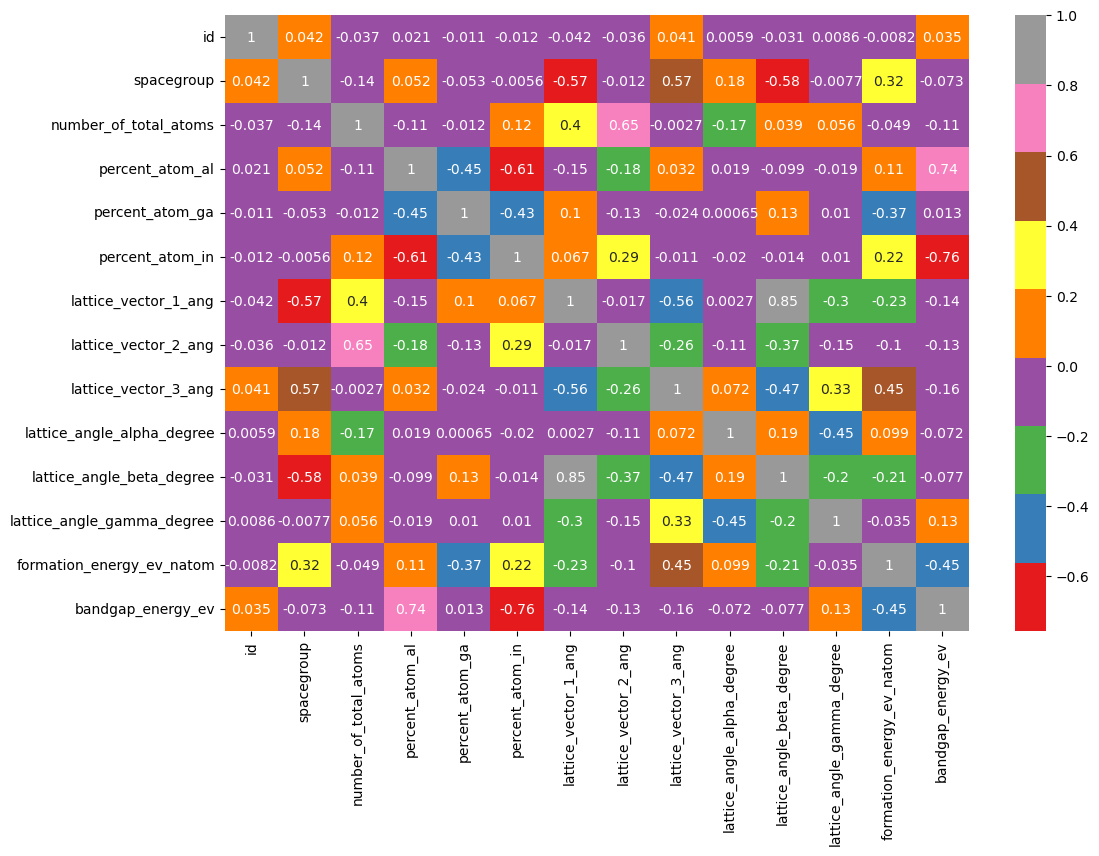

In [42]:
cor = train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor,cmap='Set1',annot=True)

#### 4.3.1추가 컬럼: degree --> radian

---

radian에 degree칼럼을 추가해줍니다.

In [43]:
# Degree to radian
train['alpha_rad'] = np.radians(train['lattice_angle_alpha_degree'])
train['beta_rad'] = np.radians(train['lattice_angle_beta_degree'])
train['gamma_rad'] = np.radians(train['lattice_angle_gamma_degree'])

test['alpha_rad'] = np.radians(test['lattice_angle_alpha_degree'])
test['beta_rad'] = np.radians(test['lattice_angle_beta_degree'])
test['gamma_rad'] = np.radians(test['lattice_angle_gamma_degree'])

#### 4.3.2 추가 컬럼: density

---

density 칼럼도 추가해줍니다.

In [44]:
def vol(df):
    volumn = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*df['lattice_vector_3_ang']*np.sqrt(
    1 + 2*np.cos(df['alpha_rad'])*np.cos(df['beta_rad'])*np.cos(df['gamma_rad'])
    -np.cos(df['alpha_rad'])**2
    -np.cos(df['beta_rad'])**2
    -np.cos(df['gamma_rad'])**2)
    df['volumn'] = volumn

In [45]:
vol(train)
vol(test)

In [46]:
# Atomic density
train['density'] = train['number_of_total_atoms'] / train['volumn']
test['density'] = test['number_of_total_atoms'] / test['volumn']

#### 4.3.3 추가 컬럼: 평균값, 중앙값

---

평균값과 중앙값또한 추가해주도록 하겠습니다.

In [47]:
def mean_median_feature(df):
        print('# Mean & Median range')
        dmean = df.mean()
        dmedian = df.median()
        #q0_1 = df.quantile(0.1)
        #q0_99 = df.quantile(0.99)
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        col = df.columns
        del_col = ['id','formation_energy_ev_natom','bandgap_energy_ev']
        col = [w for w in col if w not in del_col]
        
        for c in col:
            df['mean_'+c] = (df[c] > dmean[c]).astype(np.uint8)
            df['median_'+c] = (df[c] > dmedian[c]).astype(np.uint8)
            df['q1_'+c] = (df[c] < q1[c]).astype(np.uint8)
            df['q3_'+c] = (df[c] > q3[c]).astype(np.uint8)
            
        print('Shape',df.shape)


mean_median_feature(train)
mean_median_feature(test) 

# Mean & Median range
Shape (2400, 83)
# Mean & Median range
Shape (600, 81)


In [48]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,q1_gamma_rad,q3_gamma_rad,mean_volumn,median_volumn,q1_volumn,q3_volumn,mean_density,median_density,q1_density,q3_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0,0,1,0,0,0,1,1,0,1
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0,1,1,0,0,0,1,1,0,1
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,1,0,0,0,1,0,1,1,0,1
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0,1,0,0,1,0,1,1,0,1
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0,0,1,1,0,1,0,0,1,0


#### 4.3.4 spacegroup을 통한 데이터 그래프화

---

In [49]:
edge_node = train[['id', 'spacegroup']]

col = ['formation_energy_ev_natom','bandgap_energy_ev']
X = train.drop(['id']+col,axis=1)
y = train[col]
x_test = test.drop(['id'],axis=1)

In [50]:
edge_node

,id,spacegroup
0,1,33
1,2,194
2,3,227
3,4,167
4,5,194
...,...,...
2395,2396,33
2396,2397,167
2397,2398,206
2398,2399,33


#### 4.3.5 데이터 스케일링

---

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
x_test_scaled = sc.fit_transform(x_test)
y = y.values

In [52]:
y_test

654     5
2646    1
437     2
409     2
1338    3
       ..
1150    2
1975    4
2703    1
389     3
1776    5
Name: subject, Length: 1334, dtype: int64

In [53]:
X_scaled.shape

(2400, 80)

#### 4.3.6 그래프 데이터 전처리

---

In [54]:
# edge arry 생성 [2, num_edges].
edges = edge_node[["id", "spacegroup"]].to_numpy().T
# edge의 weight를 1로 초기화 [len(edges),]
edge_weights = tf.ones(shape=edges.shape[1])
# node의 feature array 생성 [num_nodes, num_features]
node_features = tf.cast(
    X_scaled, dtype=tf.dtypes.float32
)

# 위 정보들을 모두 담은 graph_info 튜플 변수 선언
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 2400)
Nodes shape: (2400, 80)


모델 훈련에 사용할 데이터의 전처리와 준비가 완료되었습니다. 본격적으로 예측과정을 수행해보도록 하겠습니다.

### 4.4 소재 물성 예측 모델 선언 (regression)
---

앞서 살펴본 GNN 모델과 같은 방식으로 활용하도록 하겠습니다. \
먼저 GNN Layer를 생성하고, 이후 모델 생성 함수를 정의합니다.

In [55]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_representations):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # num_nodes = tf.math.reduce_max(node_indices) + 1
        num_nodes = node_representations.shape[0]
    
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_representations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_representations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_representations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_representations, aggregated_messages)

In [56]:
# GNN 모델 선언
class GNNNodeRegressor(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeRegressor, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges - 1
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits") # enro

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)

        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        
        # Skip connection.
        x = x1 + x
        
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        
        # Skip connection.
        x = x2 + x
        
        # Postprocess node embedding.
        x = self.postprocess(x)
        
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        
        # Compute logits
        return self.compute_logits(node_embeddings)

모델 생성함수를 통해 모델을 생성하고 구조를 확인해보겠습니다.

In [57]:
gnn_model = GNNNodeRegressor(
    graph_info=graph_info,
    num_classes=2,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.2879733   0.25891998]
 [-0.17093237  0.28476855]
 [-0.6915119  -0.10726746]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2400, 32)                4096      
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 postprocess (Sequential)    (2400, 32)                2368      
                                                                 
 logits (Dense)              multiple           

데이터를 훈련과 검증을 위해 분리해줍니다. (train-test-split)

In [58]:
x_index = edge_node['id'].to_numpy()
x_train = x_index[:2000]
x_test = x_index[2000:]

y_train = y[:2000]
y_test = y[2000:]

### 4.5 소재 물성 예측 모델 학습 (regression)
---

앞서 생성한 모델을 통해 학습을 진행하겠습니다.

In [59]:
# 모델 훈련 함수
def run_experiment(model, x_train, y_train):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_rmse", patience=50, restore_best_weights=True
    )
    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [60]:
# 인풋: 노드의 인덱스
# 아웃풋: 노드와 엣지 정보를 이용하여 나온 예측결과
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300


2025-05-22 10:25:14.867833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.0393 - rmse: 1.7434

2025-05-22 10:25:17.362994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 133ms/step - loss: 3.0393 - rmse: 1.7434 - val_loss: 1.5986 - val_rmse: 1.2643
Epoch 2/300
7/7 [==============================] - 0s 31ms/step - loss: 1.0039 - rmse: 1.0019 - val_loss: 1.5424 - val_rmse: 1.2419
Epoch 3/300
7/7 [==============================] - 0s 27ms/step - loss: 0.6339 - rmse: 0.7962 - val_loss: 1.7419 - val_rmse: 1.3198
Epoch 4/300
7/7 [==============================] - 0s 30ms/step - loss: 0.4847 - rmse: 0.6962 - val_loss: 1.5155 - val_rmse: 1.2311
Epoch 5/300
7/7 [==============================] - 0s 30ms/step - loss: 0.3668 - rmse: 0.6056 - val_loss: 1.3182 - val_rmse: 1.1482
Epoch 6/300
7/7 [==============================] - 0s 30ms/step - loss: 0.2942 - rmse: 0.5424 - val_loss: 1.2710 - val_rmse: 1.1274
Epoch 7/300
7/7 [==============================] - 0s 31ms/step - loss: 0.2397 - rmse: 0.4896 - val_loss: 1.2557 - val_rmse: 1.1206
Epoch 8/300
7/7 [==============================] - 0s 30ms/step - loss: 0.1964 - rmse: 

In [61]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["rmse"])
    ax2.plot(history.history["val_rmse"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("rmse")
    plt.show()

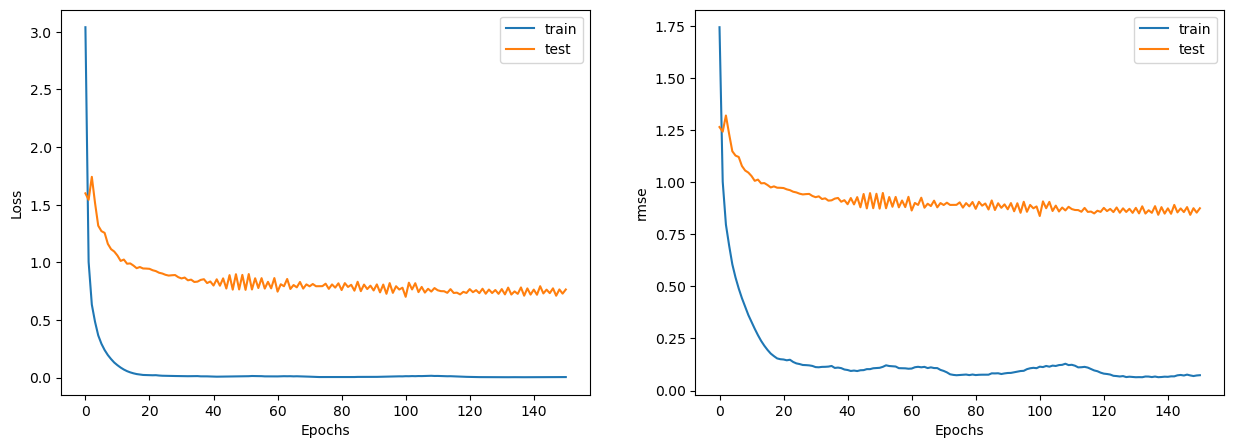

In [62]:
display_learning_curves(history)

## 5. 연습문제

---

이번 시간의 연습문제는 Cora 데이터를 직접 불러오고 전처리를 진행하며 GNN모델 훈련과 평가하는 전 과정을 복습하고, 파라미터를 직접 수정해가면서 최적의 결과를 찾아보는 과정을 수행해보겠습니다.
- 먼저 필요한 라이브러리를 불러옵니다.

In [63]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 5.1 데이터셋 불러오기

---

- Cora 데이터셋을 불러옵니다.
- 불러온 데이터셋의 'subject'를 0~7의 카테고리 형식으로 변환해줍니다.

In [64]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [65]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [66]:
#papers
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [67]:
print(papers.subject.value_counts()) # 각 주제별 데이터 (paper) 수

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [69]:
class_values = sorted(papers['subject'].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers['paper_id'].unique()))}

papers['paper_id'] = papers['paper_id'].apply(lambda name: paper_idx[name])
citations['source'] = citations['source'].apply(lambda name: paper_idx[name])
citations['target'] = citations['target'].apply(lambda name: paper_idx[name])
papers['subject'] = papers['subject'].apply(lambda value: class_idx[value])

### 5.2 GNN 인풋 준비

---

전체 데이터를 학습/시험 데이터로 분리합니다.

In [70]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # 학습 / 시험 데이터를 1:1로 분리
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1319, 1435)
Test data shape: (1389, 1435)


In [71]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# 인풋 데이터를 넘파이 데이터로 변환
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# 정답 데이터를 넘파이 데이터로 변환
y_train = train_data["subject"]
y_test = test_data["subject"]

그래프 데이터는 아래 3가지 요소로 구성되어있습니다.
- node_feature : 노드의 특성을 포함하는 넘파이 배열입니다.
- edges : 노드들 간의 희소인접행렬을 나타내는 넘파이 배열입니다.
- edge_weights : 그래프의 노드 간의 관계를 정량화하는 edge 가중치를 포함하는 넘파이 배열입니다. \
각각의 정의해 graph_info에 담아줍니다.
- 위의 3가지를 준비하는 코드를 완성하면 됩니다.

In [72]:
edges = citations[["source", "target"]].to_numpy().T

edge_weights = tf.ones(shape=edges.shape[1])

node_features = tf.cast(
    papers.sort_values('paper_id')[feature_names].to_numpy(), dtype=tf.dtypes.float32
)


graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### 5.3 GNN 모델 준비

---

- GraphConvLayer를 완성합니다.
- GNN 모델을 생성하는 코드를 완성합니다.
- 완성된 GNN모델 구조를 확인합니다.

In [ ]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == 'sum':
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'mean':
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'max':
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [73]:
# GNN 모델 선언
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type='sum',
        combination_type='concat',
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [74]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.0309698   0.10622521 -0.06208216 -0.11689616 -0.01398607  0.09677279
  -0.10133228]
 [ 0.03620276  0.0077907   0.02940075 -0.04254689  0.008068    0.05331485
  -0.0793409 ]
 [ 0.03513823  0.01823736  0.0243374  -0.01628038 -0.07259338  0.08669048
  -0.05413236]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                            

### 5.4 GNN 모델 훈련 및 평가

---

- 파라미터를 정의합니다. (hidden_units = [32, 32], lr = 0.01, dropout_rate = 0.5, 300에포크, 배치 사이즈는 256으로 설정합니다.(이후 정의된 파라미터 값들을 수정해가며 결과를 확인해봅니다.)
- 훈련 결과를 시각화하는 코드를 완성합니다.
- 훈련을 진행합니다.
- 훈련 결과를 시각화하는 코드를 완성하고, 결과를 평가합니다.

In [ ]:
#파라미터 정의
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.4
num_epochs = 200
batch_size = 256

In [113]:
# 훈련결과 시각화 함수
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'test'], loc= 'upper right')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    ax2.plot(history.history['acc'])
    ax2.plot(history.history['val_acc'])
    ax2.legend(['train', 'test'], loc= 'upper right')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    plt.show()

In [114]:
# 모델 훈련 함수
def run_experiment(model, x_train, y_train):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_acc', patience=50, restore_best_weights=True
    )
    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [115]:
x_train = train_data.paper_id.to_numpy() 
history = run_experiment(gnn_model,x_train, y_train)

Epoch 1/200


2025-05-22 10:56:00.796452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 1.1150 - acc: 0.8341

2025-05-22 10:56:03.035640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 185ms/step - loss: 1.1150 - acc: 0.8341 - val_loss: 2.7648 - val_acc: 0.3939
Epoch 2/200
5/5 [==============================] - 0s 33ms/step - loss: 0.0649 - acc: 0.9929 - val_loss: 2.6929 - val_acc: 0.3939
Epoch 3/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0385 - acc: 0.9982 - val_loss: 2.5648 - val_acc: 0.3889
Epoch 4/200
5/5 [==============================] - 0s 36ms/step - loss: 0.0259 - acc: 0.9991 - val_loss: 2.4829 - val_acc: 0.4040
Epoch 5/200
5/5 [==============================] - 0s 36ms/step - loss: 0.0167 - acc: 1.0000 - val_loss: 2.5116 - val_acc: 0.4091
Epoch 6/200
5/5 [==============================] - 0s 39ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 2.5800 - val_acc: 0.4192
Epoch 7/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 2.6610 - val_acc: 0.4091
Epoch 8/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0057 - acc: 1.0000 - val_lo

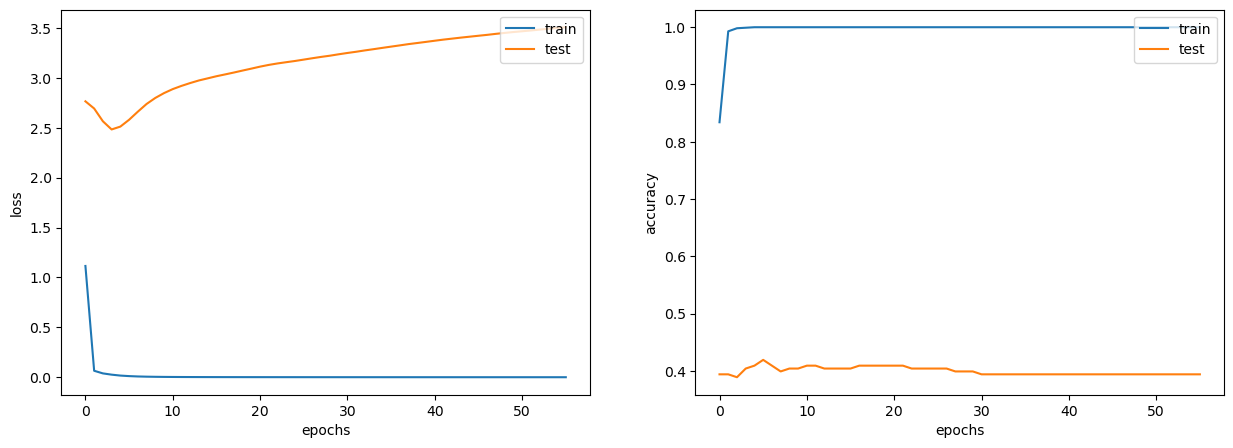

In [116]:
display_learning_curves(history)

In [111]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 35.57%


파라미터들을 바꿔가면서 accuracy의 변화를 확인해봅시다.